#Import Necessary Libraries

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_curve, auc
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

#Loading the dataset

In [54]:
# Load the dataset
file_path = '/content/parkinsons.data'  # Update with actual file path in Colab
df = pd.read_csv(file_path)



#Visualizing the basic info of the dataset

In [55]:
# Display basic info
display(df.head())
display(df.info())

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

None

### Checking the shape of the data

In [56]:
print(df.shape)

(195, 24)


#1. PD Classification using ML (Random Forest, SVM and KNN) model with SMOTE Technique

#Preprocessing the data

In [57]:
# Drop the 'name' column as it's not useful for classification
df = df.drop(columns=['name'])

### Correlation Analysis

In [58]:
print(df.shape)

(195, 23)


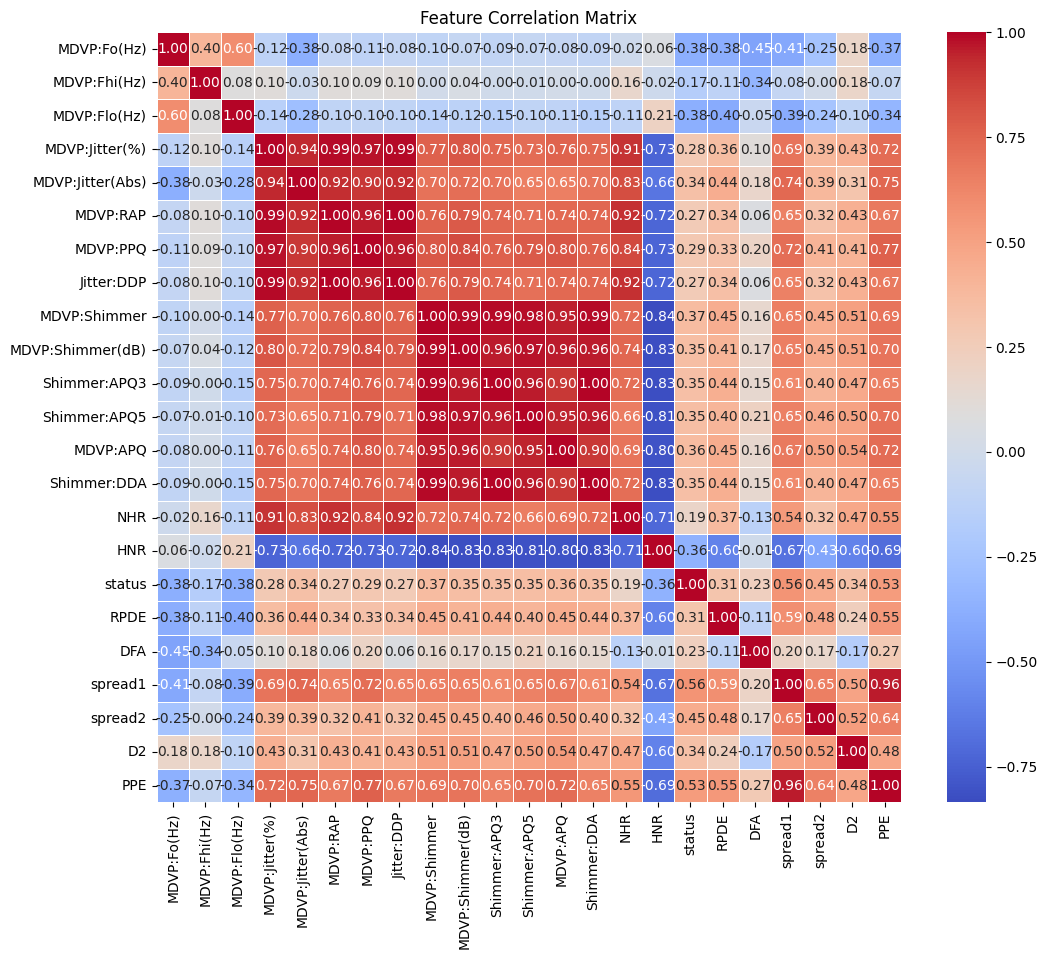

In [59]:
# Compute and display correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()


### We plot the correlation between features and with the target (status) to understand which features are important.


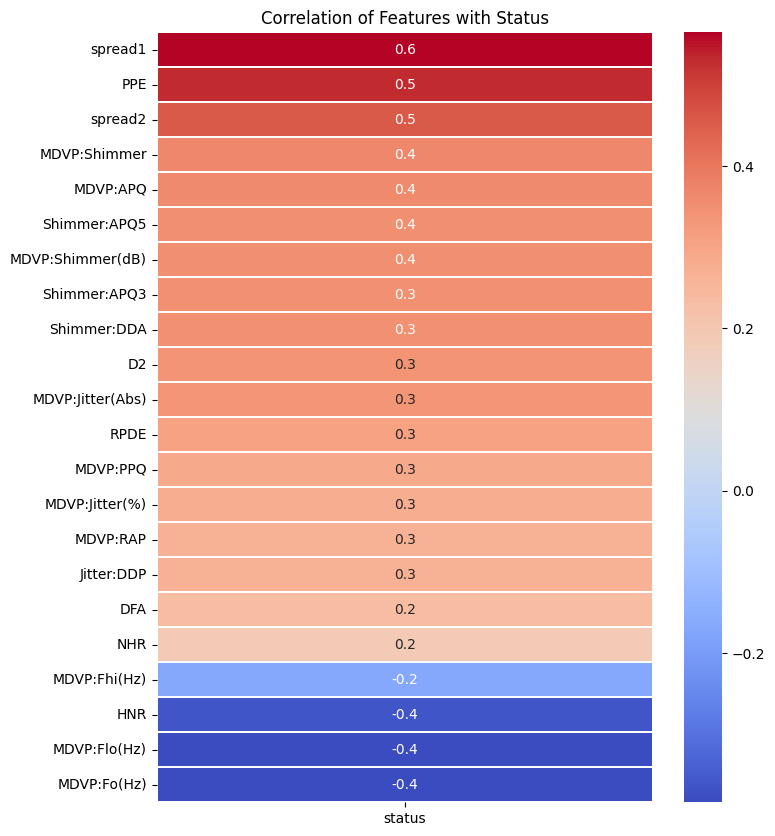

In [60]:
# Compute and display correlation matrix for 'status'
plt.figure(figsize=(8,10))
corr_with_status = df.corr()["status"].drop("status").sort_values(ascending=False)
sns.heatmap(corr_with_status.to_frame(), annot=True, cmap='coolwarm', fmt='.1f', linewidths=0.2)
plt.title("Correlation of Features with Status")
plt.show()

###Define features and target variable

In [61]:
# Define features and target variable
X = df.drop(columns=['status'])
y = df['status']

###Splitting data into train and test set
We split the dataset into training and testing subsets while keeping class distribution equal using stratify=y.

In [62]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



###Since models like SVM and KNN are sensitive to feature scales, we apply standardization (mean=0, std=1).

In [63]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


###Plotting class distribution of the unbalanced data

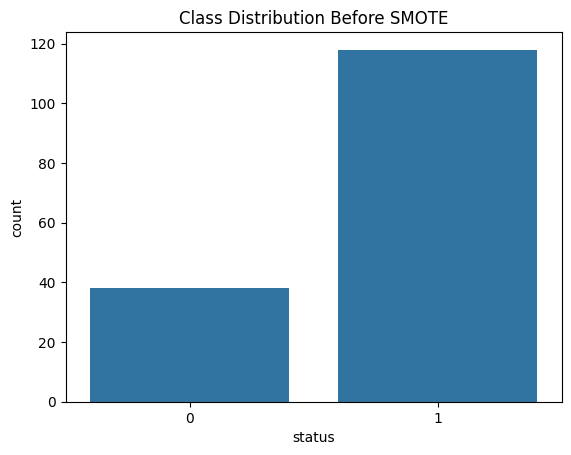

In [64]:
# Plot class distribution before SMOTE
sns.countplot(x=y_train)
plt.title("Class Distribution Before SMOTE")
plt.show()

### Applying SMOTE Technique for balancing the class distribution
SMOTE (Synthetic Minority Over-sampling Technique) generates synthetic examples of the minority class to create a balanced training set.

In [65]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)


### Plotting the balanced dataset using SMOTE

In [66]:
# Display class distribution before and after SMOTE
print("Class distribution before SMOTE:")
print(y_train.value_counts())
print("Class distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts())

Class distribution before SMOTE:
status
1    118
0     38
Name: count, dtype: int64
Class distribution after SMOTE:
status
0    118
1    118
Name: count, dtype: int64


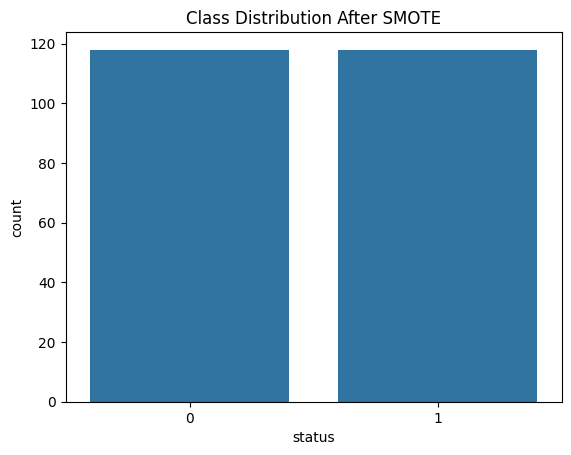

In [67]:
# Plot class distribution
sns.countplot(x=y_train_balanced)
plt.title("Class Distribution After SMOTE")
plt.show()

#Initializing Classifier with their Parameters
We’ll train three different classifiers:

Random Forest: Tree-based ensemble model.

K-Nearest Neighbors (KNN): Classifies based on nearby points.

Support Vector Machine (SVM): Finds the best hyperplane to separate classes.

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize the classifiers
rf_clf = RandomForestClassifier(random_state=42)
knn_clf = KNeighborsClassifier()
svm_clf = SVC(random_state=42)



### Traning and Evaluating Random Forest

In [69]:
# Train and evaluate Random Forest
rf_clf.fit(X_train_balanced, y_train_balanced)
rf_preds = rf_clf.predict(X_test_scaled)
print("Random Forest Classifier Results:")
print("Accuracy:", accuracy_score(y_test, rf_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_preds))
print("Classification Report:\n", classification_report(y_test, rf_preds))


Random Forest Classifier Results:
Accuracy: 0.8974358974358975
Confusion Matrix:
 [[ 9  1]
 [ 3 26]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.96      0.90      0.93        29

    accuracy                           0.90        39
   macro avg       0.86      0.90      0.87        39
weighted avg       0.91      0.90      0.90        39



### Traning and Evaluating KNN

In [70]:
# Train and evaluate KNN
knn_clf.fit(X_train_balanced, y_train_balanced)
knn_preds = knn_clf.predict(X_test_scaled)
print("K-Nearest Neighbors Classifier Results:")
print("Accuracy:", accuracy_score(y_test, knn_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, knn_preds))
print("Classification Report:\n", classification_report(y_test, knn_preds))


K-Nearest Neighbors Classifier Results:
Accuracy: 0.9230769230769231
Confusion Matrix:
 [[10  0]
 [ 3 26]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       1.00      0.90      0.95        29

    accuracy                           0.92        39
   macro avg       0.88      0.95      0.91        39
weighted avg       0.94      0.92      0.93        39



### Traning and Evaluating SVM

In [71]:
# Train and evaluate SVM
svm_clf.fit(X_train_balanced, y_train_balanced)
svm_preds = svm_clf.predict(X_test_scaled)
print("Support Vector Machine Classifier Results:")
print("Accuracy:", accuracy_score(y_test, svm_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, svm_preds))
print("Classification Report:\n", classification_report(y_test, svm_preds))

Support Vector Machine Classifier Results:
Accuracy: 0.8205128205128205
Confusion Matrix:
 [[ 9  1]
 [ 6 23]]
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.90      0.72        10
           1       0.96      0.79      0.87        29

    accuracy                           0.82        39
   macro avg       0.78      0.85      0.79        39
weighted avg       0.87      0.82      0.83        39



#Visualizing Model Performance

In [72]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

# Helper function to evaluate a model
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)  # Sensitivity
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n{model_name} Results:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Sensitivity (Recall): {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()


Random Forest Results:
Accuracy: 0.8974
Precision: 0.9630
Sensitivity (Recall): 0.8966
F1 Score: 0.9286


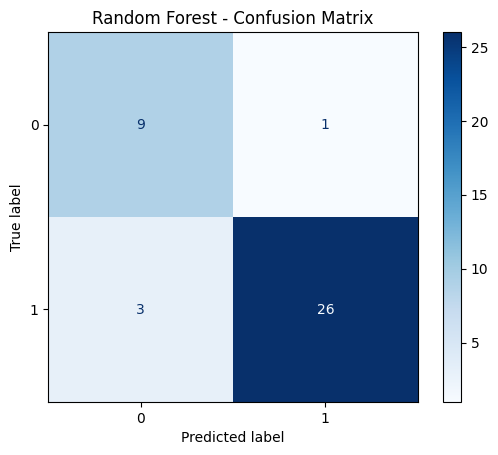

In [73]:
# Random Forest
rf_clf.fit(X_train_balanced, y_train_balanced)
evaluate_model(rf_clf, X_test_scaled, y_test, "Random Forest")


K-Nearest Neighbors Results:
Accuracy: 0.9231
Precision: 1.0000
Sensitivity (Recall): 0.8966
F1 Score: 0.9455


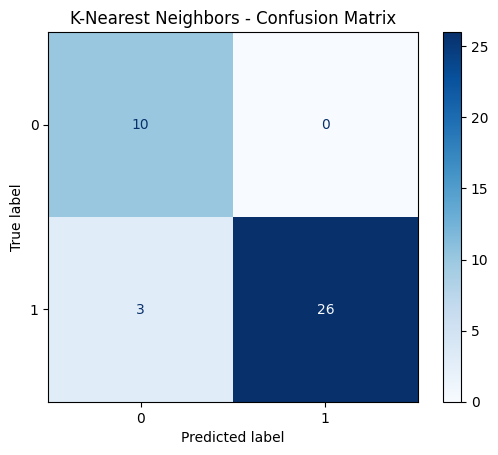

In [74]:
# KNN
knn_clf.fit(X_train_balanced, y_train_balanced)
evaluate_model(knn_clf, X_test_scaled, y_test, "K-Nearest Neighbors")


Support Vector Machine Results:
Accuracy: 0.8205
Precision: 0.9583
Sensitivity (Recall): 0.7931
F1 Score: 0.8679


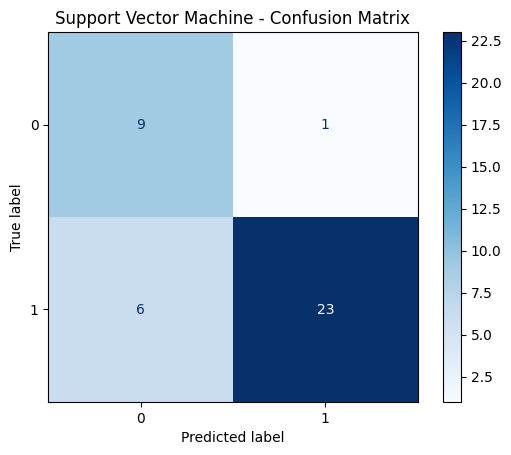

In [75]:
# SVM
svm_clf.fit(X_train_balanced, y_train_balanced)
evaluate_model(svm_clf, X_test_scaled, y_test, "Support Vector Machine")

###Comparing the ROC curves
Receiver Operating Characteristic (ROC) curves show the trade-off between true positive rate and false positive rate.

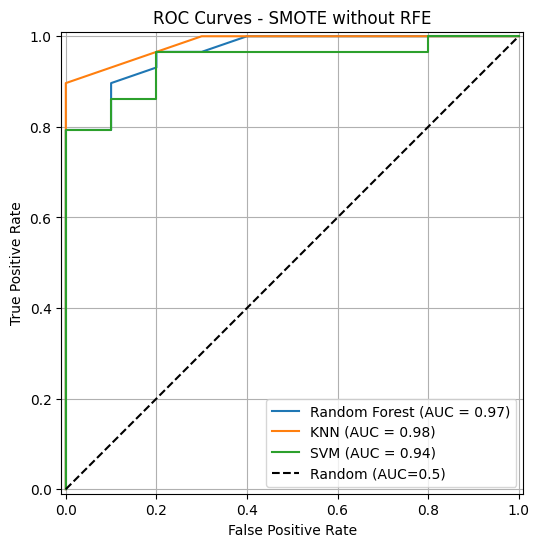

In [76]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

plt.figure(figsize=(8, 6))

# Models to compare (trained on SMOTE-balanced data)
models = {
    "Random Forest": rf_clf,
    "KNN": knn_clf,
    "SVM": svm_clf
}

# Store ROC data for legend modification
roc_data = {}

for name, model in models.items():
    # Get prediction scores
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_score = model.decision_function(X_test_scaled)

    # Compute ROC and plot
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    roc_data[name] = (fpr, tpr, roc_auc)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name).plot(ax=plt.gca())

# Plot random chance line
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.5)')

# Get current legend items
handles, labels = plt.gca().get_legend_handles_labels()

# Modify labels to include AUC (only for models, not the random line)
new_labels = []
for label in labels:
    if label in roc_data:
        new_labels.append(f"{label} (AUC={roc_data[label][2]:.2f})")
    else:
        new_labels.append(label)

# Apply the modified legend
plt.legend(handles, new_labels, loc="lower right")

plt.title("ROC Curves - SMOTE without RFE")
plt.grid()
plt.show()

###Comparing of Precision-Recall Curve

#2. PD Classification using ML (Random Forest, SVM, and KNN) with RFE-based Feature Selection and SMOTE Technique

#Preprocessing the Data

### Splitting the data into train and test set

In [77]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)



#Feature Selection using Recursive Feature Elimination (RFE)

In [78]:
# Define base estimator for RFE
base_estimator = RandomForestClassifier(random_state=42, n_estimators=100)

# Define classifiers and their hyperparameters
classifiers = {
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [None, 10, 20]
        },
        'use_scaler': False,
        'feature_selector': RFE(estimator=base_estimator, n_features_to_select=10)
    },
    'SVM': {
        'model': SVC(random_state=42, class_weight='balanced', probability=True),
        'params': {
            'model__C': [0.1, 1, 10],
            'model__kernel': ['rbf', 'linear'],
            'model__gamma': ['scale', 'auto']
        },
        'use_scaler': True,
        'feature_selector': RFE(estimator=base_estimator, n_features_to_select=10)
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'model__n_neighbors': [3, 5, 7]
        },
        'use_scaler': True,
        'feature_selector': RFE(estimator=base_estimator, n_features_to_select=10)
    }
}



#Visualizing most important features for random forest

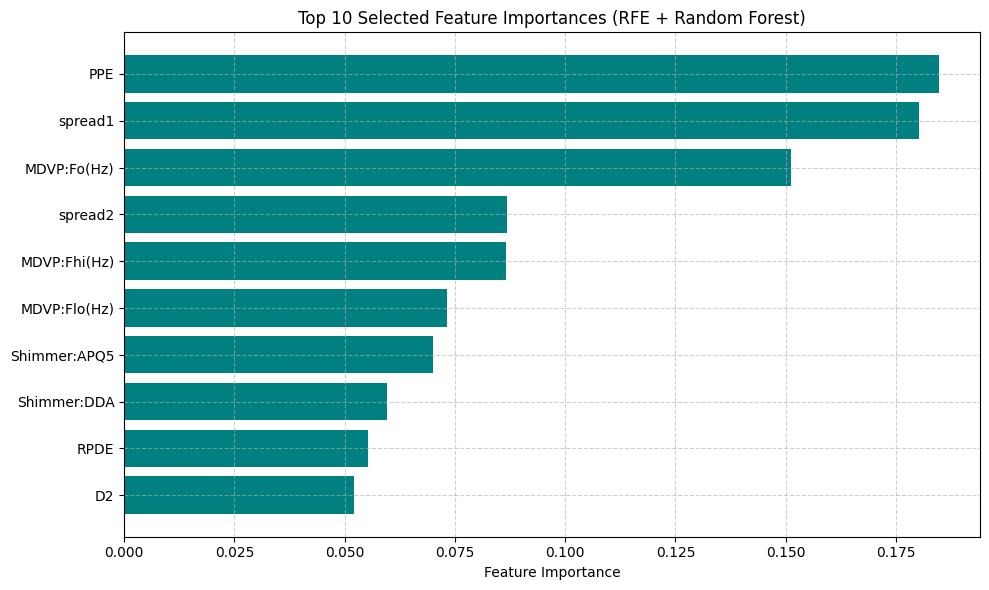

In [79]:
# 1. Define base estimator and fit RFE
base_estimator = RandomForestClassifier(random_state=42, n_estimators=100)
rfe_selector = RFE(estimator=base_estimator, n_features_to_select=10)
rfe_selector.fit(X, y)

# 2. Extract feature importances from fitted internal estimator
importances = rfe_selector.estimator_.feature_importances_
selected_features = X.columns[rfe_selector.support_]

# 3. Sort features by importance
sorted_idx = np.argsort(importances)[::-1]
sorted_features = selected_features[sorted_idx]
sorted_importances = importances[sorted_idx]

# 4. Plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color='teal')
plt.xlabel('Feature Importance')
plt.title('Top 10 Selected Feature Importances (RFE + Random Forest)')
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#Model Training and Evaluation

###Random Forest with RFE and SMOTE

In [80]:
# Train Random Forest
print("Training: Random Forest")

rf_steps = [
    ('smote', SMOTE(random_state=42)),
    ('feature_selection', RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=10)),
    ('model', RandomForestClassifier(random_state=42))
]
rf_pipeline = ImbPipeline(steps=rf_steps)

rf_params = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20]
}

rf_grid = GridSearchCV(rf_pipeline, param_grid=rf_params, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train, y_train)
best_model_rf = rf_grid.best_estimator_
y_pred_rf = best_model_rf.predict(X_test)

print("Best Parameters (RF):", rf_grid.best_params_)
print("Confusion Matrix (RF):\n", confusion_matrix(y_test, y_pred_rf))
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("Classification Report (RF):\n", classification_report(y_test, y_pred_rf, digits=4))



Training: Random Forest
Best Parameters (RF): {'model__max_depth': None, 'model__n_estimators': 100}
Confusion Matrix (RF):
 [[ 9  1]
 [ 1 28]]
Accuracy: 0.9487
Classification Report (RF):
               precision    recall  f1-score   support

           0     0.9000    0.9000    0.9000        10
           1     0.9655    0.9655    0.9655        29

    accuracy                         0.9487        39
   macro avg     0.9328    0.9328    0.9328        39
weighted avg     0.9487    0.9487    0.9487        39



### Support Vector Machine (SVM) with RFE and SMOTE

In [81]:
# Train SVM
print("\nTraining: SVM")

svm_steps = [
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('feature_selection', RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=10)),
    ('model', SVC(random_state=42, class_weight='balanced', probability=True))
]
svm_pipeline = ImbPipeline(steps=svm_steps)

svm_params = {
    'model__C': [0.1, 1, 10],
    'model__kernel': ['rbf', 'linear'],
    'model__gamma': ['scale', 'auto']
}

svm_grid = GridSearchCV(svm_pipeline, param_grid=svm_params, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train, y_train)
best_model_svm = svm_grid.best_estimator_
y_pred_svm = best_model_svm.predict(X_test)

print("Best Parameters (SVM):", svm_grid.best_params_)
print("Confusion Matrix (SVM):\n", confusion_matrix(y_test, y_pred_svm))
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print("Classification Report (SVM):\n", classification_report(y_test, y_pred_svm, digits=4))




Training: SVM
Best Parameters (SVM): {'model__C': 10, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Confusion Matrix (SVM):
 [[10  0]
 [ 4 25]]
Accuracy: 0.8974
Classification Report (SVM):
               precision    recall  f1-score   support

           0     0.7143    1.0000    0.8333        10
           1     1.0000    0.8621    0.9259        29

    accuracy                         0.8974        39
   macro avg     0.8571    0.9310    0.8796        39
weighted avg     0.9267    0.8974    0.9022        39



###K-Nearest Neighbors (KNN) with RFE and SMOTE

In [82]:
# Train KNN
print("\nTraining: KNN")

knn_steps = [
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('feature_selection', RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=10)),
    ('model', KNeighborsClassifier())
]
knn_pipeline = ImbPipeline(steps=knn_steps)

knn_params = {
    'model__n_neighbors': [ 7]
}

knn_grid = GridSearchCV(knn_pipeline, param_grid=knn_params, cv=5, scoring='accuracy', n_jobs=-1)
knn_grid.fit(X_train, y_train)
best_model_knn = knn_grid.best_estimator_
y_pred_knn = best_model_knn.predict(X_test)

print("Best Parameters (KNN):", knn_grid.best_params_)
print("Confusion Matrix (KNN):\n", confusion_matrix(y_test, y_pred_knn))
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
print("Classification Report (KNN):\n", classification_report(y_test, y_pred_knn, digits=4))




Training: KNN
Best Parameters (KNN): {'model__n_neighbors': 7}
Confusion Matrix (KNN):
 [[10  0]
 [ 3 26]]
Accuracy: 0.9231
Classification Report (KNN):
               precision    recall  f1-score   support

           0     0.7692    1.0000    0.8696        10
           1     1.0000    0.8966    0.9455        29

    accuracy                         0.9231        39
   macro avg     0.8846    0.9483    0.9075        39
weighted avg     0.9408    0.9231    0.9260        39



#Model Performance Evaluation

### Plotting Confusion Matrix

###Random Forest

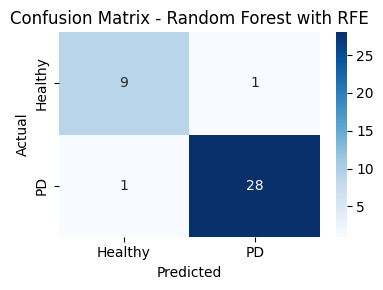

In [83]:
# Plot confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'PD'], yticklabels=['Healthy', 'PD'])
plt.title('Confusion Matrix - Random Forest with RFE')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()



###SVM Model

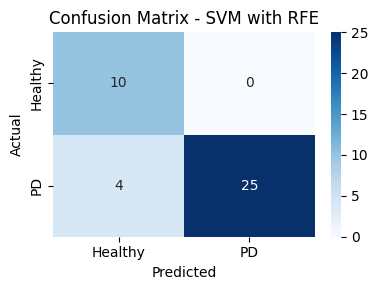

In [84]:
# Plot confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'PD'], yticklabels=['Healthy', 'PD'])
plt.title('Confusion Matrix - SVM with RFE')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()




###KNN Classifier

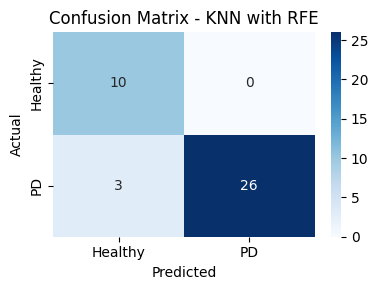

In [85]:
# Plot confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'PD'], yticklabels=['Healthy', 'PD'])
plt.title('Confusion Matrix - KNN with RFE')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


#Plotting ROC Curve

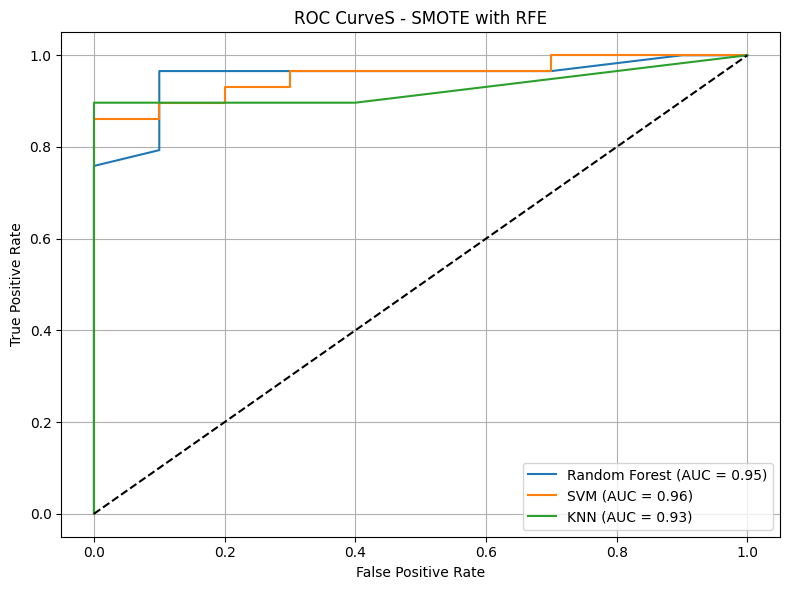

In [86]:
# Combined ROC Curve
plt.figure(figsize=(8, 6))

models = {
    'Random Forest': best_model_rf,
    'SVM': best_model_svm,
    'KNN': best_model_knn
}

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    else:
        y_score = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CurveS - SMOTE with RFE')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

